## Comparing Covid-19 cases with University population
This code loads data from various places regarding covid-19 cases and University information.  These data are defined
at the Middle Layer Super Output Are (MSOA) level

In [1]:

import pandas
import numpy as np
import requests
import os.path
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

#from uk_covid19 import Cov19API

In [2]:

# Calculate distances between lat/lon in miles.
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    dist = 3958 * dist  # 6367 for distance in KM for miles use 3958
    return dist

# simple wrapper to download datafiles from source.
def get_file(url,filename):
    #local_filename = url.split('/')[-1]
    local_filename = filename
    r = requests.get(url)
    open(local_filename, 'wb').write(r.content)
    return

def commonPlotDecoration(ax):
    plt.xlabel('')
    ax.set_xlim(right=ax.get_xlim()[1] + 1)
    # ax.xaxis.set_major_formatter( ConciseDateFormatter( '%b' ) )

    plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
                 (0, 0), (20, -50), xycoords='axes fraction',
                 textcoords='offset points', va='top',
                 fontsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [3]:

#This file contains the population weighted centroid location of each MSOA
if not os.path.isfile('./MSOA_2011_EW_PWC_COORD_V2.CSV'):
    url = "https://github.com/ITSLeeds/pct/releases/download/0.2.5/MSOA_2011_EW_PWC_COORD_V2.CSV"
    filename = url.split('/')[-1]
    get_file(url,filename)

# The sit: http://learning-provider.data.ac.uk contains lots of information for univeristy
# This includes the main locaiton of the university.  But doesn't include all campuses.
if not os.path.isfile('./learning-providers-plus.csv'):
    url = "http://learning-provider.data.ac.uk/data/learning-providers-plus.csv"
    filename = url.split('/')[-1]
    get_file(url, filename)

# # Get the latest case data from gov.uk
filename = './MSOAs_latest.csv'
# # if the file doesn't exist or it is more than 24 hours old
if not os.path.isfile(filename) or \
        (time.time() - os.path.getmtime(filename)) / (60 * 60) > 24:
    print('Getting updated case data')
    #url = "https://coronavirus.data.gov.uk/downloads/msoa_data/MSOAs_latest.csv"
    url = "https://coronavirus.data.gov.uk/api/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric=newCasesBySpecimenDateRollingRate&metric=newCasesBySpecimenDateChange&metric=newCasesBySpecimenDateDirection&format=csv"
    get_file(url,filename)

In [4]:
MSOA_centroids = pandas.read_csv('./MSOA_2011_EW_PWC_COORD_V2.CSV')

#The MSO population data comes from this table from the ONS:
#Table SAPE22DT4: Mid-2019 Population Estimates for Middle Layer Super Output Areas
#in England and Wales by Single Year of Age and Sex - Supporting Information
MSOA_pop = pandas.read_csv('./MSOA_pop.csv')
HE_centroids = pandas.read_csv('./learning-providers-plus.csv')
covidCases = pandas.read_csv('./MSOAs_latest.csv')
covidFileTimeStamp = os.path.getmtime('./MSOAs_latest.csv')

#Pop Density comes from Table QS102EW
#https://www.nomisweb.co.uk/census/2011/qs102uk
MSOA_density=pandas.read_csv('./MSOA_density.csv')
MSOA_density['msoacd']=MSOA_density['msoacd'].str.replace(' : (.*)','',regex=True)

#The student population numbers come from Table ID: DC6108EW, from the 2011 census
#https://www.nomisweb.co.uk/census/2011/dc6108ew
MSOA_student_pop = pandas.read_csv('./MSOA_student_pop.csv')
del MSOA_student_pop['date']

#Number of employees in bars/restuarants comes from the employee survey:
#https://www.nomisweb.co.uk/datasets/newbres6pub
MSOA_pubs = pandas.read_csv('./MSOA_pubs_bars.csv')
MSOA_pubs['msoacd']=MSOA_pubs['msoacd'].str.replace(' : (.*)','',regex=True)


#Definitions for several groupings of univeristies.
russell_group_rows = (HE_centroids['GROUPS'].str.contains('Russell_Group') == True)
million_plus_rows = (HE_centroids['GROUPS'].str.contains('Million') == True)
UA_rows = (HE_centroids['GROUPS'].str.contains('University_Alliance') == True)

# You can uncomment and/or change theses lines to pick a selection of unis
unis_2_keep = np.ones((len(HE_centroids.index))) > 0 # All Unis
# unis_2_keep = russell_group_rows | million_plus_rows
# unis_2_keep =  russell_group_rows
HE_centroids = HE_centroids.loc[unis_2_keep, :]

HE_lon = HE_centroids['LONGITUDE']
HE_lat = HE_centroids['LATITUDE']

# Calculate distances. NOTE: Using a for loop like this is a very slow way to do it
# but is generally more clear to read.
allDist = np.zeros((len(MSOA_centroids.index), len(HE_centroids.index)))

for index, row in MSOA_centroids.iterrows():
    this_MSOA_lon = row['LONGITUDE']
    this_MSOA_lat = row['LATITUDE']

    theseDist = haversine(this_MSOA_lon, this_MSOA_lat, HE_lon, HE_lat)
    allDist[index,] = theseDist

#Calculate the distance to nearest university.
uni_distance = np.nanmin(allDist, axis=1)
rg_distance = np.nanmin(allDist[:, russell_group_rows], axis=1)
mp_distance = np.nanmin(allDist[:, million_plus_rows], axis=1)
closestUniIdx = np.nanargmin(allDist, axis=1)
tmp = allDist
#Stupid way to remove non russell group from disance calc.  Just set the distance to highvalue
tmp[:, (-1*russell_group_rows.values+1)==1]=10000
closestRgIdx = np.nanargmin(tmp, axis=1)

uni_name = HE_centroids['PROVIDER_NAME'].iloc[closestUniIdx].values
rg_name  = HE_centroids['PROVIDER_NAME'].iloc[closestRgIdx].values
groups   = HE_centroids['GROUPS'].iloc[closestUniIdx].values
MSOA_centroids.insert(1, "uni_distance", uni_distance)
MSOA_centroids.insert(1, "rg_distance", rg_distance)
MSOA_centroids.insert(1, "mp_distance", mp_distance)
MSOA_centroids.insert(1, "uni_name", uni_name)
MSOA_centroids.insert(1, "rg_name", rg_name)
MSOA_centroids.insert(1, "GROUPS", groups)






In [5]:

# Put together the various dataframes above into one merged dataframe.  

merged = pandas.merge(left=MSOA_centroids, right=covidCases, left_on='MSOA11CD', right_on='areaCode')
merged = pandas.merge(left=merged, right=MSOA_pop, left_on='MSOA11CD', right_on='MSOA Code')
merged = pandas.merge(left=merged, right=MSOA_student_pop, left_on='MSOA11CD', right_on='MSOA Code')
merged = pandas.merge(left=merged, right=MSOA_density, left_on='MSOA11CD', right_on='msoacd')
merged = pandas.merge(left=merged, right=MSOA_pubs, left_on='MSOA11CD', right_on='msoacd')

merged['date'] = pandas.to_datetime(merged['date'],format='%Y-%m-%d')

merged = merged.replace(-99, 0)
merged = merged.sort_values('uni_distance')

#Normalize by MSOA population
#merged['latest_7_days_per_100k'] = 1e5 * merged.filter(like='latest_7_days').div(merged['Total Pop'], axis=0)
merged['Student Percentage'] = merged['Student Population'] / merged['Total Pop']



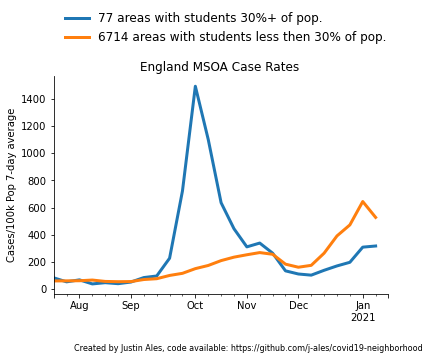

In [6]:
# Separate English MSOA by student concentation.
### 
popThresh = .3
###

highStudent = merged.loc[merged['Student Percentage'] >= popThresh]
lowStudent = merged.loc[merged['Student Percentage'] < popThresh]

highData= highStudent.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
lowData= lowStudent.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()

numberHigh=len(highStudent['areaCode'].unique())
numberLow=len(lowStudent['areaCode'].unique())

fig, ax = plt.subplots(1, 1)
highData.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
lowData.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)

plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberHigh,popThresh),
        '{} areas with students less then {:.0%} of pop.'.format(numberLow,popThresh)],
           frameon=False,fontsize=12,loc="lower left",bbox_to_anchor=(0,1.1))
plt.ylabel('Weekly Cases per 100k')


plt.title('England MSOA Case Rates ')
ax = plt.gca()
commonPlotDecoration(ax)
plt.ylabel('Cases/100k Pop 7-day average')
plt.show()

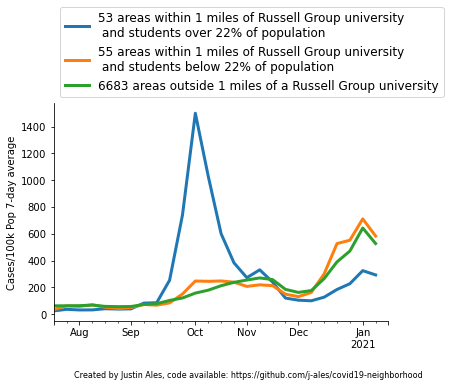

In [7]:

# Look at all Russel Group Universities in England as a group 

###

popThresh = .22
distThresh = 1
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
#uniGroup   = 'uni_distance'
uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[~((merged[uniGroup] < distThresh) & selectTheseUni), :]

numberClose=len(close['areaCode'].unique())
numberFar=len(far['areaCode'].unique())
numberRest=len(rest['areaCode'].unique())
close= close.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
far= far.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
rest= rest.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()

fig, ax = plt.subplots(1, 1)
close.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
far.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
rest.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)

plt.legend(['{} areas within {} miles of Russell Group university\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
             '{} areas within {} miles of Russell Group university\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside {} miles of a Russell Group university'.format(numberRest,distThresh)],
              fontsize=12,loc="lower left",bbox_to_anchor=(0,1))
commonPlotDecoration(ax)
plt.ylabel('Cases/100k Pop 7-day average')
plt.show()

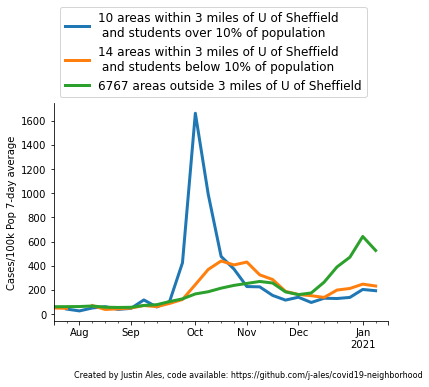

In [8]:

# Pull out just U Sheffield

###
popThresh = .10
distThresh = 3
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
uniGroup   = 'uni_distance'
#uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)
selectTheseUni = (merged['uni_name']=='UNIVERSITY OF SHEFFIELD')

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[~((merged[uniGroup] < distThresh) & selectTheseUni), :]

numberClose=len(close['areaCode'].unique())
numberFar=len(far['areaCode'].unique())
numberRest=len(rest['areaCode'].unique())
close= close.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
far= far.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
rest= rest.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()

fig, ax = plt.subplots(1, 1)
close.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
far.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
rest.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)

plt.legend(['{} areas within {} miles of U of Sheffield\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
             '{} areas within {} miles of U of Sheffield\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside {} miles of U of Sheffield'.format(numberRest,distThresh)],
              fontsize=12,loc="lower left",bbox_to_anchor=(0,1))
commonPlotDecoration(ax)
plt.ylabel('Cases/100k Pop 7-day average')
plt.show()

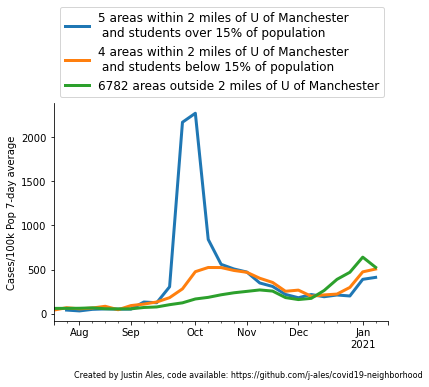

In [9]:
# Pull out just U Manchester

###
popThresh = .15
distThresh = 2
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
uniGroup   = 'uni_distance'
#uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)
uniNameToChoose = 'THE UNIVERSITY OF MANCHESTER'
selectTheseUni = (merged['uni_name']==uniNameToChoose)

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[ ~((merged[uniGroup] < distThresh) & selectTheseUni), :]

numberClose=len(close['areaCode'].unique())
numberFar=len(far['areaCode'].unique())
numberRest=len(rest['areaCode'].unique())
close= close.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
far= far.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
rest= rest.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()

fig, ax = plt.subplots(1, 1)
close.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
far.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
rest.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)

plt.legend(['{} areas within {} miles of U of Manchester\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
             '{} areas within {} miles of U of Manchester\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside {} miles of U of Manchester'.format(numberRest,distThresh)],
            fontsize=12,loc="lower left",bbox_to_anchor=(0,1))
commonPlotDecoration(ax)
plt.ylabel('Cases/100k Pop 7-day average')
plt.show()

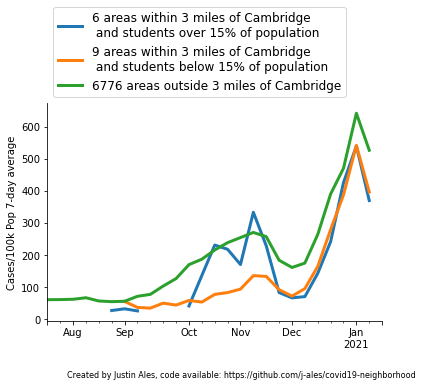

In [10]:
# Pull out just U Cambridge

###
popThresh = .15
distThresh = 3
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
uniGroup   = 'uni_distance'
#uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)
#selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD') | (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')
#selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD')
selectTheseUni = (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[~((merged[uniGroup] < distThresh) & selectTheseUni), :]

numberClose=len(close['areaCode'].unique())
numberFar=len(far['areaCode'].unique())
numberRest=len(rest['areaCode'].unique())
close= close.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
far= far.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()
rest= rest.groupby(['date'])[['newCasesBySpecimenDateRollingRate']].mean()

fig, ax = plt.subplots(1, 1)
close.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
far.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)
rest.plot(y='newCasesBySpecimenDateRollingRate',ax=ax,linewidth=3)

plt.legend(['{} areas within {} miles of Cambridge\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
             '{} areas within {} miles of Cambridge\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside {} miles of Cambridge'.format(numberRest,distThresh)],
              fontsize=12,loc="lower left",bbox_to_anchor=(0,1))
commonPlotDecoration(ax)
plt.ylabel('Cases/100k Pop 7-day average')
plt.show()